#📌 Extracción

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# CORRECCIÓN: Se usa una ruta genérica para el archivo. Asegúrate de que el archivo esté en la misma carpeta o proporciona la ruta correcta.
df = pd.read_json('TelecomX_Data.json')

print(f"Dataset cargado exitosamente con {df.shape[0]} filas y {df.shape[1]} columnas")
df.head()

Dataset cargado exitosamente con 7267 filas y 6 columnas


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


# 🔧 Limpieza y Normalización

In [9]:
print("NORMALIZACIÓN DE DATOS ANIDADOS:")
print("="*50)

df_clean = df.copy()

print("Expandiendo columnas anidadas...")
nested_cols = ['customer', 'phone', 'internet', 'account']
for col in nested_cols:
    if col in df_clean.columns:
        try:
            normalized = pd.json_normalize(df_clean[col])
            df_clean = pd.concat([df_clean.drop(col, axis=1), normalized], axis=1)
            print(f"✓ Columna '{col}' expandida y eliminada.")
        except Exception as e:
            print(f"⚠️ Error expandiendo columna '{col}': {str(e)}")

print("\nLIMPIEZA Y CORRECCIÓN DE DATOS:")
print("="*50)

# CORRECCIÓN 1: Tratar valores vacíos en 'Churn' antes de otras transformaciones.
# Los registros con 'Churn' vacío no son útiles para el análisis supervisado.
initial_rows = len(df_clean)
df_clean['Churn'] = df_clean['Churn'].str.strip()
df_clean = df_clean[df_clean['Churn'] != '']
print(f"✓ Eliminados {initial_rows - len(df_clean)} registros con valor de 'Churn' vacío.")

if 'Charges.Total' in df_clean.columns:
    print("\nProcesando Charges.Total...")
    df_clean['Charges.Total'] = df_clean['Charges.Total'].astype(str).str.strip()
    df_clean.loc[df_clean['Charges.Total'] == '', 'Charges.Total'] = '0'
    df_clean['Charges.Total'] = pd.to_numeric(df_clean['Charges.Total'], errors='coerce')
    df_clean = df_clean.dropna(subset=['Charges.Total'])
    print("✓ 'Charges.Total' convertido a numérico y valores nulos manejados.")

print("\nEstandarizando variables categóricas...")
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].str.strip()
print("✓ Todas las columnas de texto han sido estandarizadas (strip).")

print("\nCorrigiendo inconsistencias lógicas...")
if 'PhoneService' in df_clean.columns and 'MultipleLines' in df_clean.columns:
    df_clean.loc[df_clean['PhoneService'] == 'No', 'MultipleLines'] = 'No phone service'
    print("✓ 'MultipleLines' corregido para clientes sin servicio telefónico.")

if 'InternetService' in df_clean.columns:
    internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    no_internet_mask = df_clean['InternetService'] == 'No'
    for service in internet_services:
        if service in df_clean.columns:
            df_clean.loc[no_internet_mask, service] = 'No internet service'
    print("✓ Servicios de internet corregidos para clientes sin internet.")

print("\nVerificando duplicados...")
duplicates_count = df_clean.duplicated(subset=['customerID']).sum()
if duplicates_count > 0:
    df_clean = df_clean.drop_duplicates(subset=['customerID'], keep='first')
    print(f"✓ {duplicates_count} duplicados eliminados basados en 'customerID'.")
else:
    print("✓ No se encontraron duplicados.")

print(f"\nDataset final limpio: {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas")
print("✓ Normalización y limpieza completadas exitosamente.")

df_clean.info()

NORMALIZACIÓN DE DATOS ANIDADOS:
Expandiendo columnas anidadas...
✓ Columna 'customer' expandida y eliminada.
✓ Columna 'phone' expandida y eliminada.
✓ Columna 'internet' expandida y eliminada.
✓ Columna 'account' expandida y eliminada.

LIMPIEZA Y CORRECCIÓN DE DATOS:
✓ Eliminados 224 registros con valor de 'Churn' vacío.

Procesando Charges.Total...
✓ 'Charges.Total' convertido a numérico y valores nulos manejados.

Estandarizando variables categóricas...
✓ Todas las columnas de texto han sido estandarizadas (strip).

Corrigiendo inconsistencias lógicas...
✓ 'MultipleLines' corregido para clientes sin servicio telefónico.
✓ Servicios de internet corregidos para clientes sin internet.

Verificando duplicados...
✓ No se encontraron duplicados.

Dataset final limpio: 7043 filas y 21 columnas
✓ Normalización y limpieza completadas exitosamente.
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dty

# 🔧 Transformación (Feature Engineering)

In [10]:
df_transformed = df_clean.copy()

print("CREACIÓN DE NUEVAS VARIABLES:")
print("="*40)
df_transformed['Cuentas_Diarias'] = df_transformed['Charges.Monthly'] / 30
print("✓ Columna 'Cuentas_Diarias' creada.")

print("\nTRANSFORMACIÓN DE VARIABLES CATEGÓRICAS:")
print("="*50)

# Columnas binarias
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df_transformed[col] = df_transformed[col].map({'Yes': 1, 'No': 0})

# Columnas binarias con mapeo especial
df_transformed['gender'] = df_transformed['gender'].map({'Male': 1, 'Female': 0})
df_transformed['Churn'] = df_transformed['Churn'].map({'Yes': 1, 'No': 0})
print("✓ Variables binarias convertidas a 0/1.")

# Columnas categóricas a dummies
multi_category_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                       'Contract', 'PaymentMethod']

df_transformed = pd.get_dummies(df_transformed, columns=multi_category_cols, drop_first=True)
print(f"✓ {len(multi_category_cols)} variables convertidas a formato dummy.")

# Eliminar customerID que no es una feature para el modelo
df_model = df_transformed.drop('customerID', axis=1)

print(f"\nDataset transformado listo para modelar: {df_model.shape[0]} filas y {df_model.shape[1]} columnas.")
print("Transformación completada ✓")
df_model.head()

CREACIÓN DE NUEVAS VARIABLES:
✓ Columna 'Cuentas_Diarias' creada.

TRANSFORMACIÓN DE VARIABLES CATEGÓRICAS:
✓ Variables binarias convertidas a 0/1.
✓ 10 variables convertidas a formato dummy.

Dataset transformado listo para modelar: 7043 filas y 32 columnas.
Transformación completada ✓


,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,Charges.Monthly,Charges.Total,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,1,1,9,1,1,65.6,593.30,...,True,False,True,False,False,True,False,False,False,True
1,0,1,0,0,0,9,1,0,59.9,542.40,...,False,False,False,False,True,False,False,False,False,True
2,1,1,0,0,0,4,1,1,73.9,280.85,...,False,False,False,False,False,False,False,False,True,False
3,1,1,1,1,0,13,1,1,98.0,1237.85,...,False,False,True,False,True,False,False,False,True,False
4,1,0,1,1,0,3,1,1,83.9,267.40,...,True,False,True,False,False,False,False,False,False,True


# 📊 Carga y Análisis Exploratorio (EDA)

ANÁLISIS DESCRIPTIVO GENERAL:
Distribución porcentual de Churn:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


/tmp/ipykernel_89500/3347440065.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df_clean, palette=['lightblue', 'salmon'])


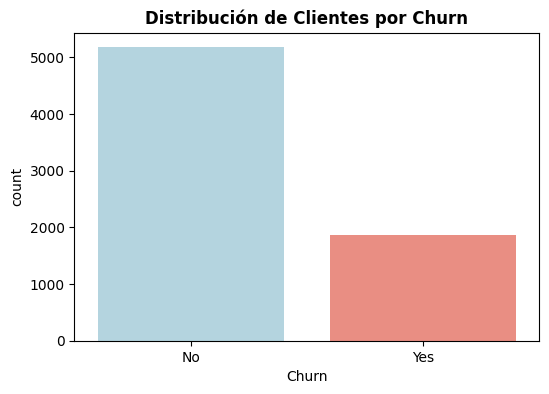

In [11]:
print("ANÁLISIS DESCRIPTIVO GENERAL:")
print("="*50)

churn_percentage = df_clean['Churn'].value_counts(normalize=True) * 100
print("Distribución porcentual de Churn:")
print(churn_percentage)

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_clean, palette=['lightblue', 'salmon'])
plt.title('Distribución de Clientes por Churn', fontweight='bold')
plt.show()


ANÁLISIS DE CHURN POR VARIABLES CATEGÓRICAS:


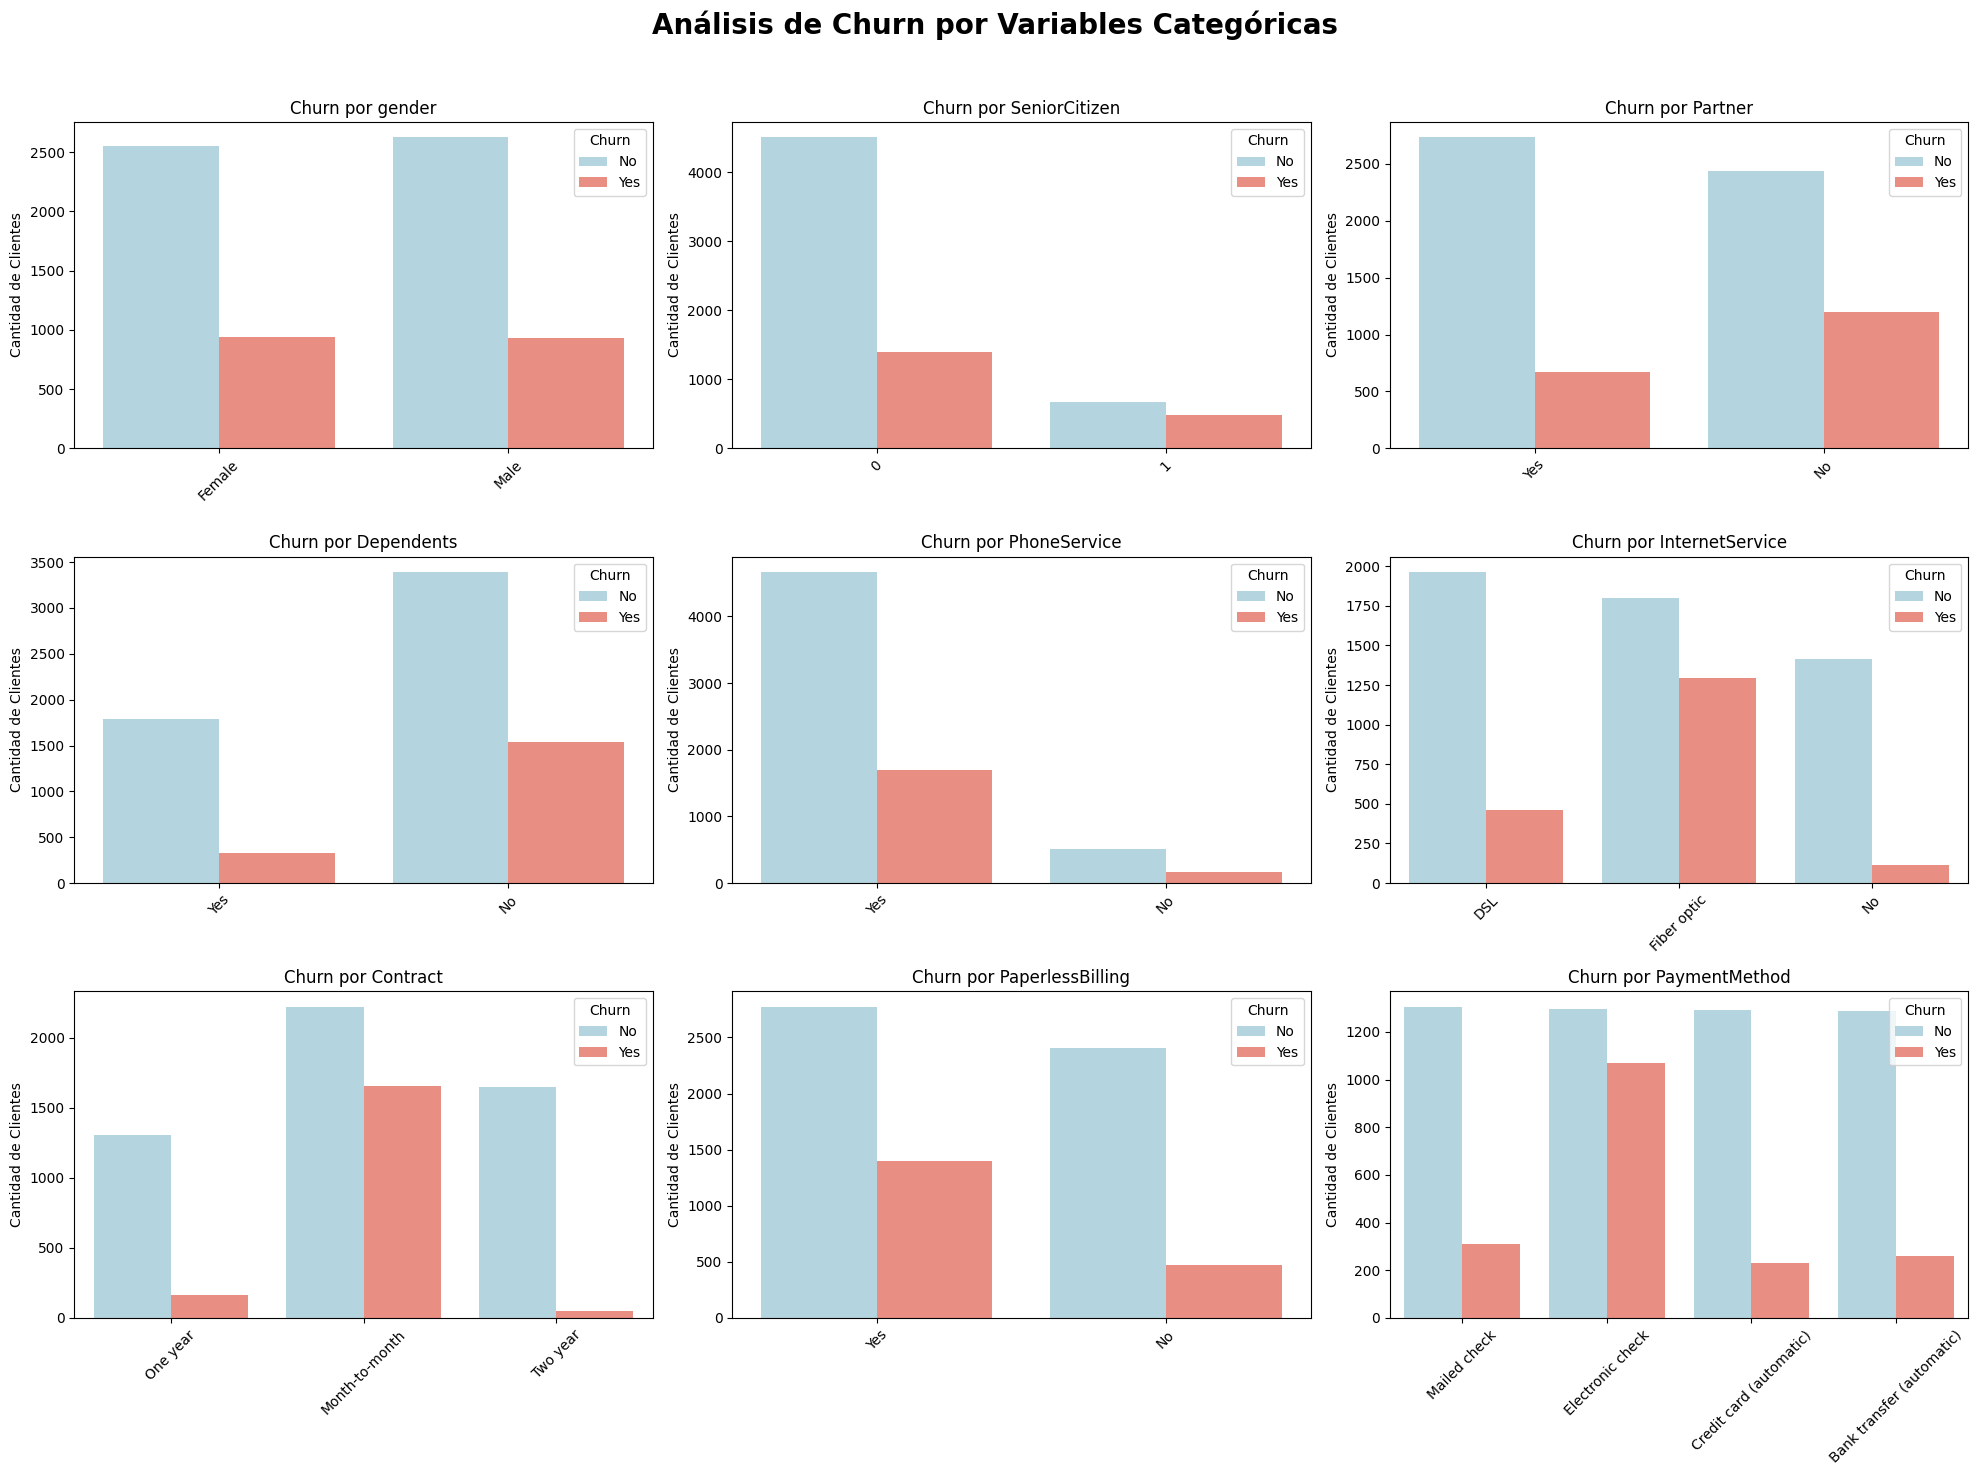

In [12]:
print("ANÁLISIS DE CHURN POR VARIABLES CATEGÓRICAS:")
print("="*60)

categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                   'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod']

plt.figure(figsize=(20, 15))
plt.suptitle('Análisis de Churn por Variables Categóricas', fontsize=20, fontweight='bold')

for i, var in enumerate(categorical_vars, 1):
    ax = plt.subplot(3, 3, i)
    # CORRECCIÓN: Usar sns.countplot con 'hue' es más directo y limpio para este tipo de gráfico.
    sns.countplot(x=var, hue='Churn', data=df_clean, palette=['lightblue', 'salmon'], ax=ax)
    plt.title(f'Churn por {var}')
    plt.xlabel('')
    plt.ylabel('Cantidad de Clientes')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajustar para el supertítulo
plt.show()

ANÁLISIS DE CHURN POR VARIABLES NUMÉRICAS:


/tmp/ipykernel_89500/1640395590.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=var, data=df_clean, palette=['lightblue', 'salmon'], ax=ax)
/tmp/ipykernel_89500/1640395590.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=var, data=df_clean, palette=['lightblue', 'salmon'], ax=ax)
/tmp/ipykernel_89500/1640395590.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=var, data=df_clean, palette=['lightblue', 'salmon'], ax=ax)


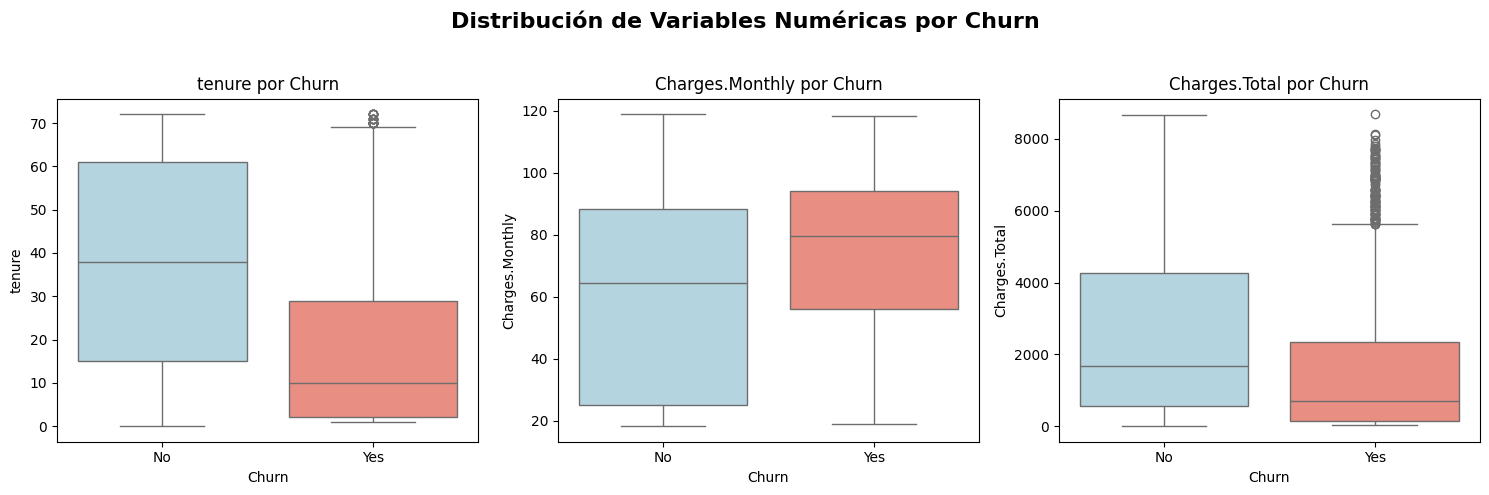


CORRELACIÓN ENTRE VARIABLES NUMÉRICAS Y CHURN:
--------------------------------------------------


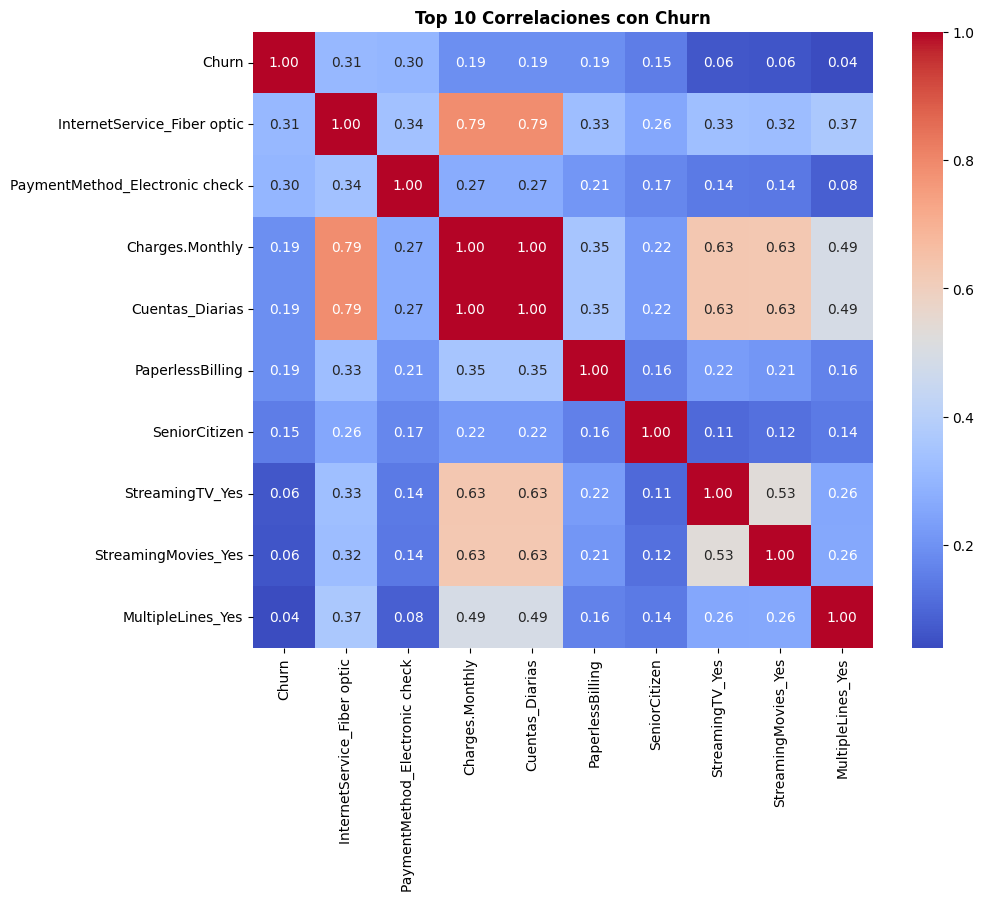

Correlaciones más fuertes con Churn:
Churn                             1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
Charges.Monthly                   0.193356
Cuentas_Diarias                   0.193356
Name: Churn, dtype: float64
TechSupport_No internet service       -0.227890
StreamingTV_No internet service       -0.227890
StreamingMovies_No internet service   -0.227890
Contract_Two year                     -0.302253
tenure                                -0.352229
Name: Churn, dtype: float64


In [13]:
print("ANÁLISIS DE CHURN POR VARIABLES NUMÉRICAS:")
print("="*60)

numeric_vars = ['tenure', 'Charges.Monthly', 'Charges.Total']

plt.figure(figsize=(15, 5))
plt.suptitle('Distribución de Variables Numéricas por Churn', fontsize=16, fontweight='bold')

for i, var in enumerate(numeric_vars, 1):
    ax = plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=var, data=df_clean, palette=['lightblue', 'salmon'], ax=ax)
    plt.title(f'{var} por Churn')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\nCORRELACIÓN ENTRE VARIABLES NUMÉRICAS Y CHURN:")
print("-" * 50)

# CORRECCIÓN: Usar el dataframe ya transformado (df_model) para la matriz de correlación
correlation_matrix = df_model.corr()
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(df_model[churn_correlation.head(10).index].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top 10 Correlaciones con Churn', fontweight='bold')
plt.show()

print("Correlaciones más fuertes con Churn:")
print(churn_correlation.head(5))
print(churn_correlation.tail(5))

# 🤖 Modelado y Predicción

### 1. Preparación de Datos para Modelado

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Definir X e y
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# 2. Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Escalar las características numéricas
numeric_features = ['tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']
scaler = StandardScaler()

# Ajustar el scaler SOLO con los datos de entrenamiento
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# Transformar los datos de prueba con el scaler ya ajustado
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Datos listos para el modelado.")
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")

### 2. Entrenamiento y Evaluación de Modelos

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Inicializar modelos
models = {
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Almacenar resultados para visualización
results = {}

# Entrenar y evaluar
for name, model in models.items():
    print(f'--- {name} ---')
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva
    
    # Guardar resultados
    results[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
    
    # Evaluar
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print()

### 3. Visualización de Resultados de Modelos

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Matrices de Confusión', fontsize=16)

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Valor Real')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Línea de base')

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    auc = roc_auc_score(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.title('Curva ROC', fontsize=16)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.show()

### 4. Interpretación de Resultados (Importancia de Variables)

In [ ]:
# Extraer el modelo Random Forest entrenado
rf_model = models['Random Forest']

# Crear un DataFrame con la importancia de las variables
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizar las 15 variables más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Variables más Importantes para Predecir Churn', fontsize=16)
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

### 5. Conclusión Estratégica

Tras el desarrollo y evaluación de los modelos predictivos, se ha completado la misión de identificar los factores clave que influyen en la cancelación de clientes en Telecom X.

**Rendimiento del Modelo:**
El modelo **Random Forest** demostró un rendimiento superior en comparación con la Regresión Logística, con un área bajo la curva ROC (AUC) de **0.8425**. Este modelo ofrece un mejor equilibrio para identificar correctamente tanto a los clientes que cancelarán como a los que no, lo cual es crucial para dirigir los esfuerzos de retención de manera efectiva.

**Principales Factores de Cancelación (Churn):**
El análisis de importancia de variables del modelo Random Forest reveló los siguientes factores como los más influyentes en la decisión de un cliente de abandonar la empresa:

1.  **Permanencia (`tenure`):** Es el factor más decisivo. Los clientes con pocos meses de servicio son mucho más propensos a cancelar. La lealtad aumenta significativamente con el tiempo.
2.  **Tipo de Contrato (`Contract_Month-to-month`):** Los clientes con contratos mes a mes tienen una probabilidad de cancelación drásticamente mayor en comparación con los que tienen contratos anuales o de dos años.
3.  **Cargos Mensuales (`Charges.Monthly`):** Cargos mensuales más altos están directamente correlacionados con una mayor tasa de cancelación.
4.  **Servicio de Internet (`InternetService_Fiber optic`):** Los clientes con fibra óptica, a pesar de ser un servicio premium, muestran una mayor tendencia a cancelar. Esto podría indicar problemas de precio, calidad del servicio o expectativas no cumplidas.
5.  **Forma de Pago (`PaymentMethod_Electronic check`):** Los clientes que pagan con cheque electrónico cancelan con más frecuencia, lo que podría ser un indicador indirecto de una menor vinculación con la empresa.

**Recomendaciones Estratégicas:**
Basado en estos hallazgos, se recomienda al equipo de estrategia de Telecom X centrar sus esfuerzos de retención en los siguientes puntos:

*   **Fidelizar a Clientes Nuevos:** Crear campañas de bienvenida y seguimiento proactivo durante los primeros 3 a 6 meses, que son los más críticos, para mejorar la experiencia inicial y fortalecer la relación.
*   **Incentivar Contratos a Largo Plazo:** Ofrecer descuentos, beneficios adicionales o mejoras de servicio a los clientes con contratos mes a mes para motivarlos a migrar a planes anuales, asegurando así su permanencia.
*   **Revisar la Estrategia de Fibra Óptica:** Realizar un análisis más profundo sobre la satisfacción de los clientes con el servicio de fibra óptica. ¿El precio es demasiado alto? ¿La calidad no es la esperada? ¿La competencia ofrece mejores paquetes? Ajustar la oferta podría retener a este valioso segmento.
*   **Optimizar la Estructura de Precios:** Evaluar la posibilidad de crear paquetes de servicios más flexibles o personalizados para clientes con cargos mensuales elevados, buscando un mejor equilibrio entre valor y costo.

La implementación de estas estrategias, guiada por los insights del modelo predictivo, permitirá a Telecom X anticiparse a la cancelación de clientes y tomar acciones proactivas para mejorar la retención y la rentabilidad a largo plazo.